# Generar SVGs de provincias y departamentos

In [1]:
from __future__ import unicode_literals, print_function
%matplotlib inline
from matplotlib import  pyplot as plt
import geopandas as gpd
import svgis
from IPython.display import SVG, display, display_svg
import os
import re
import itertools
import glob

In [83]:
def show_svg(filename):
    return SVG(filename=filename)

## Generar un svg por cada provincia y por cada departamento

In [91]:
def geometries_to_svg(shp_path, shps_dir, svgs_dir, 
                      id_field="departamento_id", geometry_field="geometry"):
    df = gpd.read_file(shp_path, encoding="latin1")

    # TODO: revisar esta linea ad-hoc
    df.rename(columns={"link": "departamento_id", "nombre": "departamento_nombre"}, inplace=True)

    # separa el shp en un shp y un svg para cada figura
    for i in xrange(len(df)):
        msg = "Procesando la figura {}, de, {}".format(i + 1, len(df))
        print(msg, end="\r"*len(msg))
        
        # crea el shp individual
        file_name_shp = df.loc[i, id_field] + ".shp"
        file_path_shp = os.path.join(shps_dir, file_name_shp)
        df.iloc[i:i+1].to_file(file_path_shp)
        
        # crea el svg individual
        svg = svgis.SVGIS(file_path_shp)
        file_name_svg = df.loc[i, id_field] + ".svg"
        file_path_svg = os.path.join(svgs_dir, file_name_svg)
        with open(file_path_svg, "wb") as f:
            f.write(svg.compose())

In [84]:
# geometries_to_svg(
#    shp_path="data/provincias/pxprovdatos.shp",
#    shps_dir="data/provincias/shp", svgs_dir="data/provincias/svg"
#)

In [85]:
#geometries_to_svg(
#    shp_path="data/departamentos/pxdptodatos.shp",
#    shps_dir="data/departamentos/shp", svgs_dir="data/departamentos/svg"
#)

## Generar un SVG de departamentos taggeado con sus ids, por c/provincia

In [2]:
df_depto = gpd.read_file("data/departamentos/pxdptodatos.shp", encoding="utf8", crs="4326")

In [3]:
df_depto.rename(columns={"link": "departamento_id", "nombre": "departamento_nombre"}, inplace=True)
df_depto["provincia_id"] = df_depto.departamento_id.str[:2]

shps_dir = "data/prov_deptos/shp"
svgs_dir = "data/prov_deptos/svg"

In [5]:
def gdf_to_svg(gdf, file_path_svg, shape_id_field):
    """Genera un SVG a partir de los shapes de un geodataframe, con ids."""

    # crea una figura nueva
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    # itera los ids de los shape del geodataframe
    for shape_id in gdf[shape_id_field].unique():
        
        # genera un plot de c/shape, y lo agrega a los axes de la figura completa
        gdf[gdf[shape_id_field] == shape_id].to_crs({"init": "epsg:3395"}).plot(color="white", ax=ax)

        # ax va acumulando todos los nuevos patches que se generan por cada
        # shape. Se iteran todos los patches asignando el id del shape a todos
        # los nuevos (los patches que todavía no tienen id)
        for patch in ax.patches:
            if not patch.get_gid():
                patch.set_gid(shape_id)

    ax.set_aspect("equal")
    plt.axis("off")
    plt.savefig(file_path_svg)

In [6]:
def gdf_to_svgs(gdf, split_id_field, shape_id_field, svgs_dir):
    """Genera varios SVGs con shapes identificadas, separando por un campo."""
    
    for split_id in gdf[split_id_field].unique():
        msg = "Procesando la figura {}".format(split_id)
        print(msg)
        
        file_name_svg = split_id + ".svg"
        file_path_svg = os.path.join(svgs_dir, file_name_svg)
        
        gdf_to_svg(gdf[gdf[split_id_field] == split_id], file_path_svg, shape_id_field)

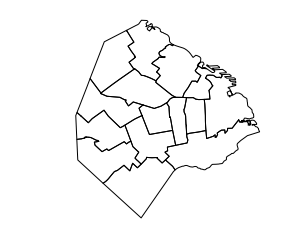

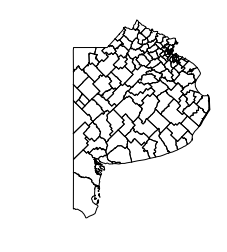

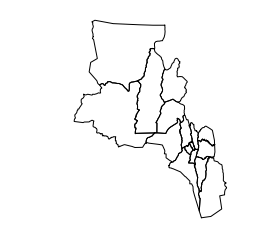

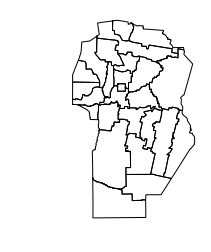

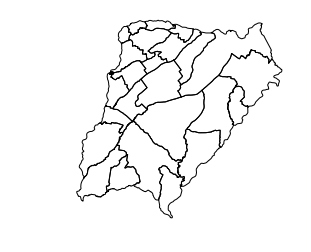

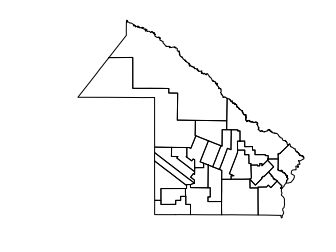

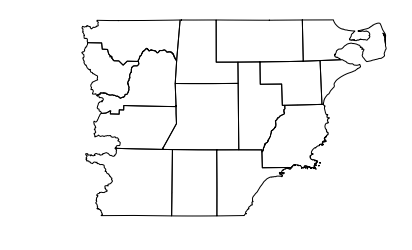

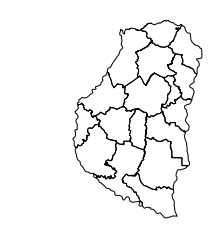

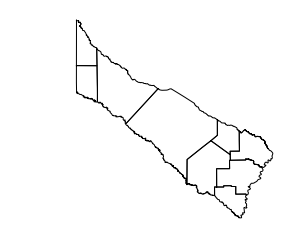

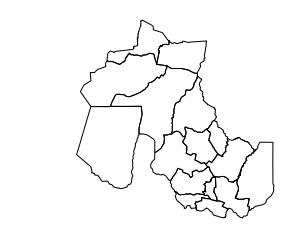

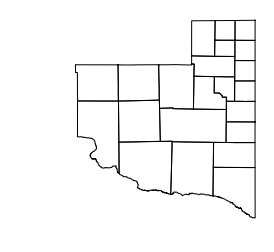

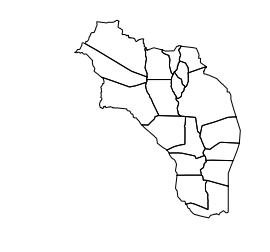

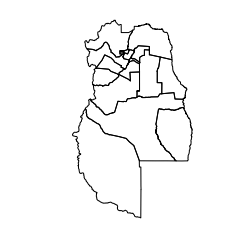

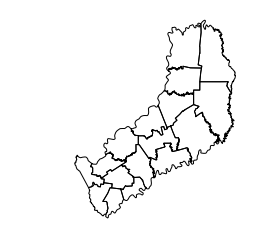

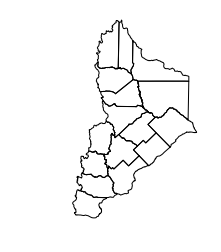

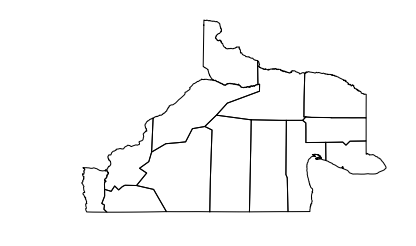

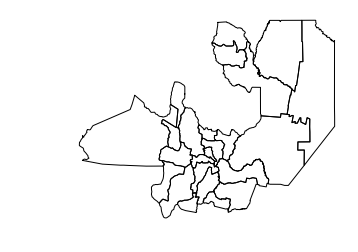

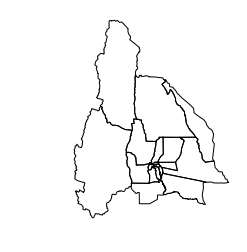

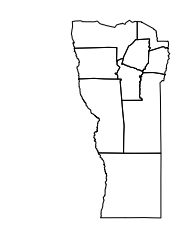

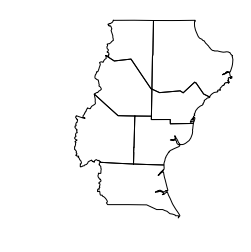

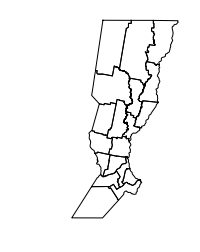

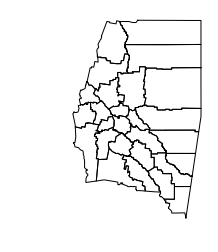

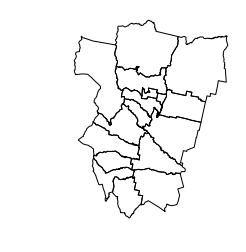

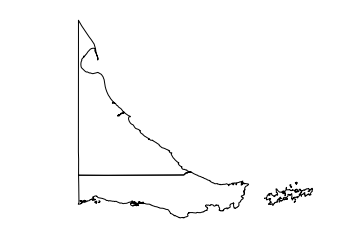

In [20]:
df_depto_sin_antartida = df_depto[~df_depto.departamento_id.isin(["94021", "94028"])]
gdf_to_svgs(df_depto_sin_antartida, "provincia_id", "departamento_id", svgs_dir)